In [43]:
import math
import random
import sys

import matplotlib.pyplot as plt
import shapefile
from shapely.geometry import Polygon, Point

from src.util import Const

In [44]:
myshp = open(Const.SPATIAL_SHP_FILE_PATH, 'rb')
myshx = open(Const.SPATIAL_SHX_FILE_PATH, 'rb')
mydbf = open(Const.SPATIAL_DBF_FILE_PATH, 'rb')

reader = shapefile.Reader(shp=myshp, shx=myshx, dbf=mydbf)

del myshp, myshx, mydbf

In [45]:
shapes = reader.shapes()
points = shapes[5].points

del reader, shapes

In [46]:
class AttributeDict(dict):
    __slots__ = ()
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

options = AttributeDict()

options.minWidth = 0
# Default value for the number of possible center points of the maximal rectangle
options.nTries = 20
options.tolerance = 0.02
options.angle = math.radians(90)
options.aspectRatio = 650 / 450

In [47]:
polygon = Polygon(points)

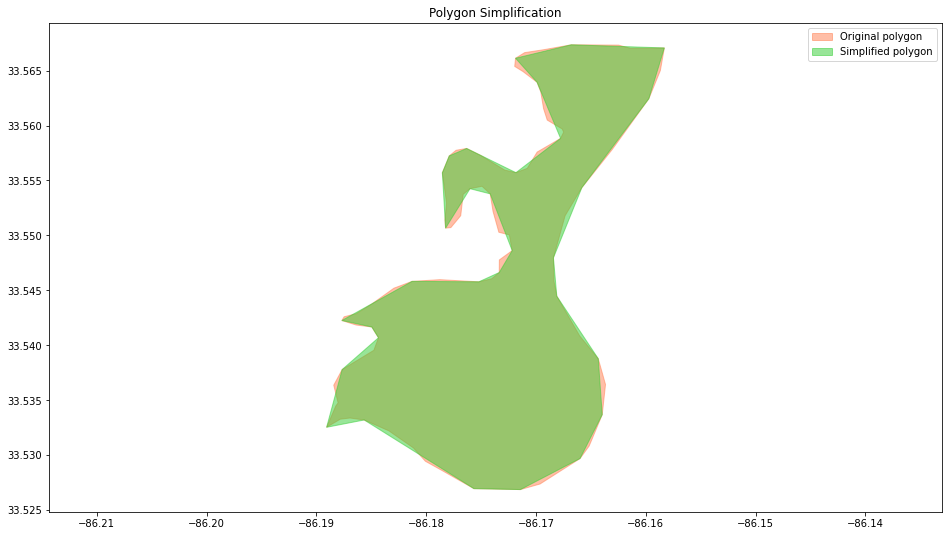

In [48]:
# get the width of the bounding box of the original polygon to determine tolerance
minx, miny, maxx, maxy = polygon.bounds

# simplify polygon
old_polygon = Polygon(polygon)
tolerance = min(maxx - minx, maxy - miny) * options.tolerance
if tolerance > 0:
    polygon = polygon.simplify(tolerance)

plt.figure(figsize=(16, 9))
plt.title('Polygon Simplification')
plt.axis('equal')
plt.fill(
    old_polygon.exterior.coords.xy[0],
    old_polygon.exterior.coords.xy[1],
    color='coral',
    alpha=0.5,
    label='Original polygon',
)
plt.fill(
    polygon.exterior.coords.xy[0],
    polygon.exterior.coords.xy[1],
    color='limegreen',
    alpha=0.5,
    label='Simplified polygon',
)
plt.legend()
plt.show()

del tolerance

In [49]:
# get the width of the bounding box of the simplified polygon
minx, miny, maxx, maxy = polygon.bounds
[boxWidth, boxHeight] = [maxx - minx, maxy - miny]

# discretize the binary search for optimal width to a resolution of this times the polygon width
widthStep = min(boxWidth, boxHeight) / 50

del maxx, maxy

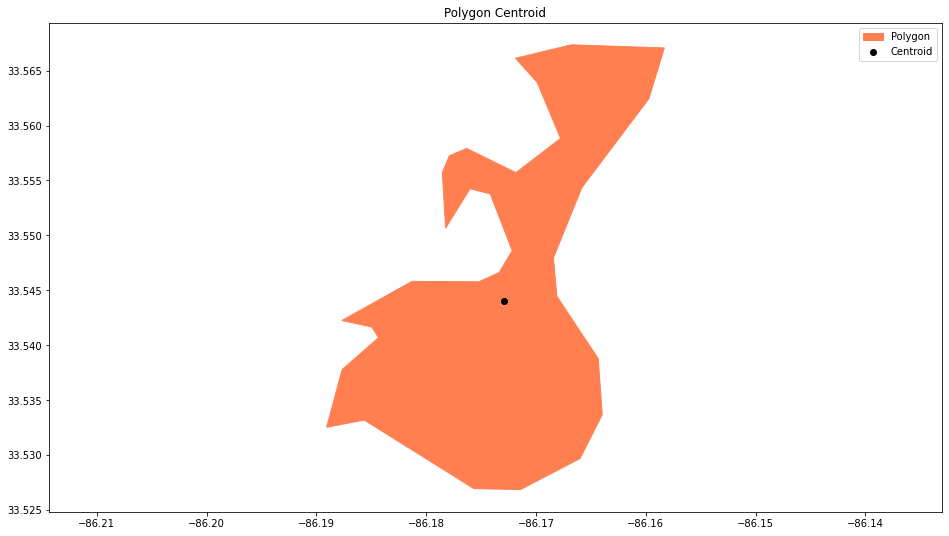

In [50]:
# populate possible center points with random points inside the polygon
origins = []

# get the centroid of the polygon
centroid = polygon.centroid

if centroid.within(polygon):
    origins.append(centroid)

plt.figure(figsize=(16, 9))
plt.title('Polygon Centroid')
plt.axis('equal')
plt.fill(
    polygon.exterior.coords.xy[0],
    polygon.exterior.coords.xy[1],
    color='coral',
    zorder=1,
    label='Polygon'
)
plt.scatter(
    centroid.x,
    centroid.y,
    color='black',
    zorder=2,
    label='Centroid'
)
plt.legend()
plt.show()

del centroid

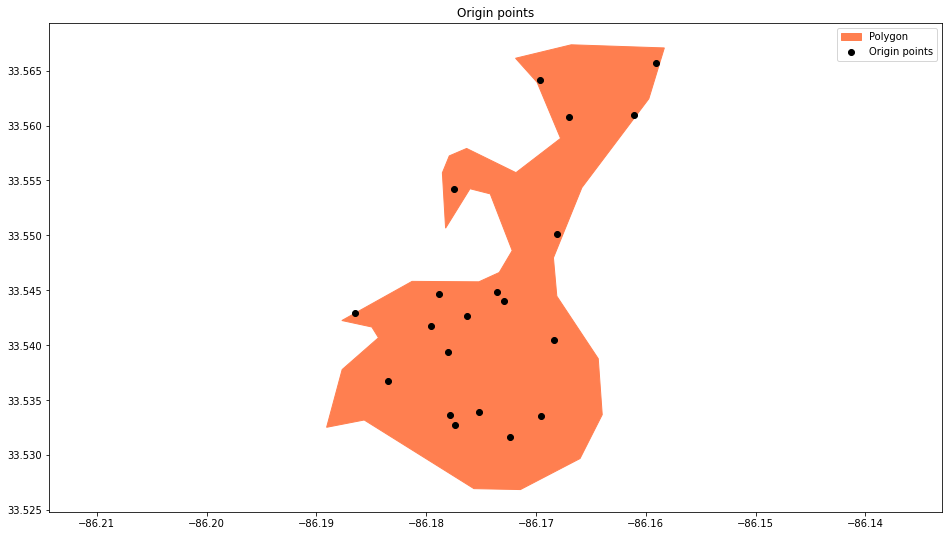

In [51]:
# get few more points inside the polygon

while len(origins) < options.nTries:
    rndX = random.random() * boxWidth + minx
    rndY = random.random() * boxHeight + miny
    rndPoint = Point(rndX, rndY)
    if rndPoint.within(polygon):
        origins.append(rndPoint)

plt.figure(figsize=(16, 9))
plt.title('Origin points')
plt.axis('equal')
plt.fill(
    polygon.exterior.coords.xy[0],
    polygon.exterior.coords.xy[1],
    color='coral',
    zorder=1,
    label='Polygon'
)

x = [point.x for point in origins]
y = [point.y for point in origins]

plt.scatter(
    x,
    y,
    color='black',
    zorder=2,
    label='Origin points'
)
plt.legend()

plt.show()

del rndX, rndY, rndPoint, x, y
del minx, miny, boxWidth, boxHeight

In [52]:
# Returns the squared euclidean distance between points a and b
def squaredDist(a: Point, b: Point) -> float:
    deltax = b.x - a.x
    deltay = b.y - a.y

    return deltax * deltax + deltay * deltay

In [53]:
def lineIntersection(p1: Point, q1: Point, p2: Point, q2: Point) -> Point or None:
    '''
    Finds the intersection point (if there is one) of the lines p1q1 and p2q2

    :param p1: Line #1 start point
    :param q1: Line #1 end point
    :param p2: Line #2 start point
    :param q2: Line #2 end point
    :return: Point of intersection
    '''
    # allow for some margins due to numerical errors
    eps = 1e-9
    # find the intersection point between the two infinite lines
    dx1 = p1.x - q1.x
    dy1 = p1.y - q1.y
    dx2 = p2.x - q2.x
    dy2 = p2.y - q2.y
    denom = dx1 * dy2 - dy1 * dx2

    if math.fabs(denom) < eps:
        return None

    cross1 = p1.x * q1.y - p1.y * q1.x
    cross2 = p2.x * q2.y - p2.y * q2.x

    px = (cross1 * dx2 - cross2 * dx1) / denom
    py = (cross1 * dy2 - cross2 * dy1) / denom

    return Point(px, py)

In [54]:

def pointInSegmentBox(p: Point, p1: Point, q1: Point) -> bool:
    '''
    Checks whether the point `p` is inside the bounding box of the line segment `p1q1`

    :param p: Check point
    :param p1: Line segment start point
    :param q1: Line segment end point
    :return: `True` if point is in segment box. `False` otherwise
    '''
    # allow for some margins due to numerical errors
    eps = 1e-9
    if p.x < min(p1.x, q1.x) - eps or \
        p.x > max(p1.x, q1.x) + eps or \
        p.y < min(p1.y, q1.y) - eps or \
        p.y > max(p1.y, q1.y) + eps:
        return False

    return True

In [55]:

def intersectPoints(poly: Polygon, origin: Point, alpha: float) -> (Point, Point):
    '''
    Gives the 2 closest intersection points between a ray with alpha radians from
    the origin and the polygon. The two points should lie on opposite sides of the origin

    :param poly: Polygon
    :param origin: Origin point
    :param alpha: Angle
    :return: 2 closest points between a ray with alpha radians from the origin and the polygon
    '''
    eps = 1e-9
    origin = Point(origin.x + eps * math.cos(alpha), origin.y + eps * math.sin(alpha))
    shiftedOrigin = Point(origin.x + math.cos(alpha), origin.y + math.sin(alpha))

    idx = 0
    if math.fabs(shiftedOrigin.x - origin.x) < eps:
        idx = 1

    i = 0
    n = len(poly.exterior.coords)
    b = Point(poly.exterior.coords[n - 1])
    minSqDistLeft = sys.float_info.max
    minSqDistRight = sys.float_info.max
    closestPointLeft = None
    closestPointRight = None
    while i < n:
        a = Point(b)
        b = Point(poly.exterior.coords[i])

        p = lineIntersection(origin, shiftedOrigin, a, b)
        if p is not None and pointInSegmentBox(p, a, b):
            sqDist = squaredDist(origin, p)
            if p.coords[0][idx] < origin.coords[0][idx]:
                if sqDist < minSqDistLeft:
                    minSqDistLeft = sqDist
                    closestPointLeft = Point(p)
            elif p.coords[0][idx] > origin.coords[0][idx]:
                if sqDist < minSqDistRight:
                    minSqDistRight = sqDist
                    closestPointRight = Point(p)
        i += 1

    return closestPointLeft, closestPointRight

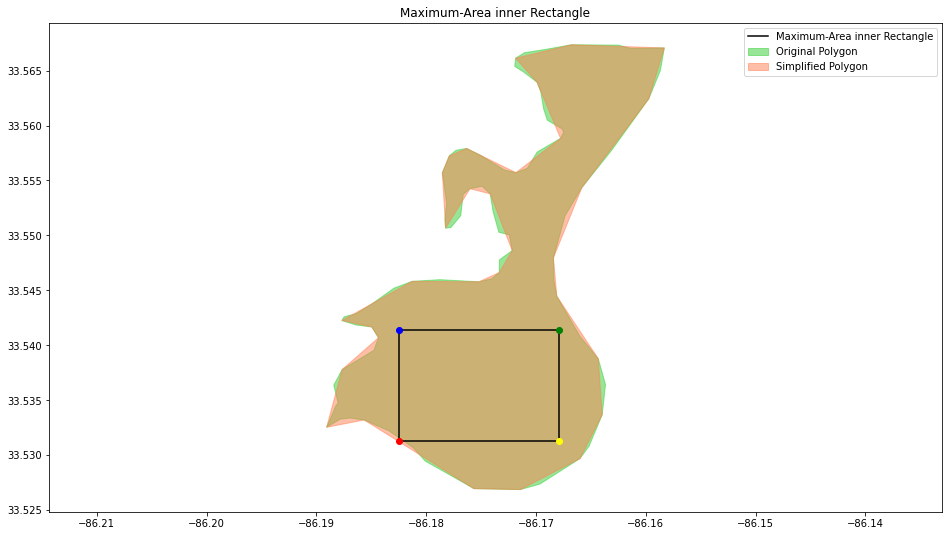

In [56]:
maxArea = 0
maxRect = None

for origOrigin in origins:
    # generate improved origins
    p1W, p2W = intersectPoints(polygon, origOrigin, options.angle)
    p1H, p2H = intersectPoints(polygon, origOrigin, options.angle + math.pi / 2)
    modifOrigins = []
    if p1W is not None and p2W is not None:
        # average along with width axis
        modifOrigins.append(Point((p1W.x + p2W.x) / 2, (p1W.y + p2W.y) / 2))
    if p1H is not None and p2H is not None:
        # average along with height axis
        modifOrigins.append(Point((p1H.x + p2H.x) / 2, (p1H.y + p2H.y) / 2))

    for origin in modifOrigins:
        p1W, p2W = intersectPoints(polygon, origin, options.angle)
        if p1W is None or p2W is None:
            continue

        minSqDistW = min(squaredDist(origin, p1W), squaredDist(origin, p2W))
        maxWidth = 2 * math.sqrt(minSqDistW)

        p1H, p2H = intersectPoints(polygon, origin, options.angle + math.pi / 2)
        if p1H is None or p2H is None:
            continue

        minSqDistH = min(squaredDist(origin, p1H), squaredDist(origin, p2H))
        maxHeight = 2 * math.sqrt(minSqDistH)

        if maxWidth * maxHeight < maxArea:
            continue

        # do a binary search to find the max width that works
        left = max(options.minWidth, math.sqrt(maxArea * options.aspectRatio))
        right = min(maxWidth, maxHeight * options.aspectRatio)
        if right * maxHeight < maxArea:
            continue

        while (right - left) >= widthStep:
            width = (left + right) / 2
            height = width / options.aspectRatio
            rectPoly = Polygon([
                Point(origin.x - width / 2, origin.y - height / 2),
                Point(origin.x + width / 2, origin.y - height / 2),
                Point(origin.x + width / 2, origin.y + height / 2),
                Point(origin.x - width / 2, origin.y + height / 2),
            ])
            if rectPoly.within(polygon):
                # we know that the area is already greater than the maxArea found so far
                maxArea = width * height
                maxRect = {
                    'cx': origin.x,
                    'cy': origin.y,
                    'width': width,
                    'height': height,
                }
                # increase the width in the binary search
                left = width
            else:
                # decrease the width in the binary search
                right = width

width = maxRect['width']
height = maxRect['height']

half_width = width / 2
half_height = height / 2

innerRect = Polygon([
    Point(maxRect['cx'] - half_width, maxRect['cy'] - half_height),
    Point(maxRect['cx'] - half_width, maxRect['cy'] + half_height),
    Point(maxRect['cx'] + half_width, maxRect['cy'] + half_height),
    Point(maxRect['cx'] + half_width, maxRect['cy'] - half_height),
])

plt.figure(figsize=(16, 9))
plt.title('Maximum-Area inner Rectangle')
plt.axis('equal')
plt.fill(
    old_polygon.exterior.coords.xy[0],
    old_polygon.exterior.coords.xy[1],
    color='limegreen',
    zorder=1,
    alpha=0.5,
    label='Original Polygon'
)
plt.fill(
    polygon.exterior.coords.xy[0],
    polygon.exterior.coords.xy[1],
    color='coral',
    zorder=2,
    alpha=0.5,
    label='Simplified Polygon'
)
plt.plot(
    innerRect.exterior.coords.xy[0],
    innerRect.exterior.coords.xy[1],
    color='black',
    zorder=3,
    label='Maximum-Area inner Rectangle'
)

plt.scatter(
    innerRect.exterior.coords[0][0],
    innerRect.exterior.coords[0][1],
    color='red',
    zorder=4,
)
plt.scatter(
    innerRect.exterior.coords[1][0],
    innerRect.exterior.coords[1][1],
    color='blue',
    zorder=4,
)
plt.scatter(
    innerRect.exterior.coords[2][0],
    innerRect.exterior.coords[2][1],
    color='green',
    zorder=4,
)
plt.scatter(
    innerRect.exterior.coords[3][0],
    innerRect.exterior.coords[3][1],
    color='yellow',
    zorder=4,
)
plt.legend()

plt.show()

del p1W, p2W, p1H, p2H
del width, widthStep, height, left, right, rectPoly, polygon, points, origin, origins, origOrigin, modifOrigins
del options, old_polygon, minSqDistW, minSqDistH, maxArea, maxRect, maxHeight, maxWidth, half_width, half_height